# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [194]:
# Load pickled data
import pickle

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [195]:
print(len(X_train))
assert len(X_train) == len(y_train)
      
print(len(X_test))
assert len(X_test) == len(y_test)


39209
12630


In [196]:
### To start off let's do a basic data summary.

n_train = len(y_train)

n_test = len(y_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


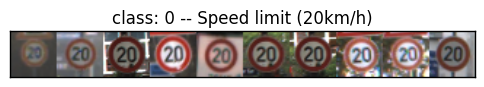

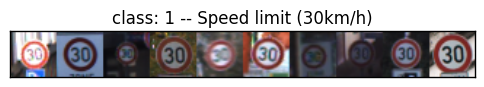

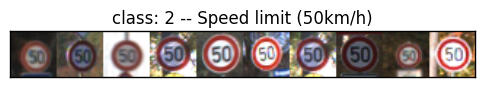

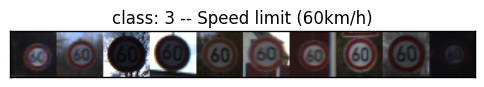

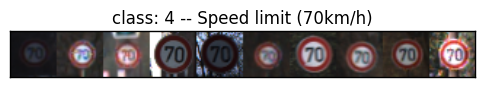

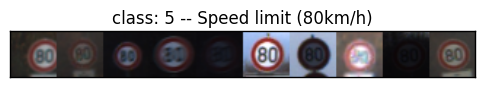

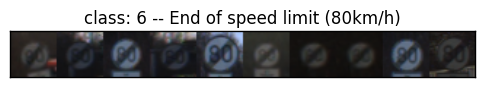

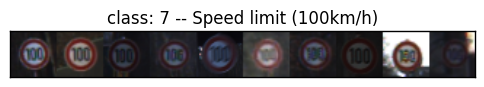

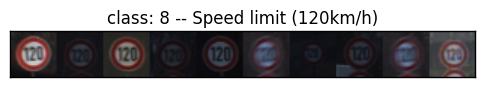

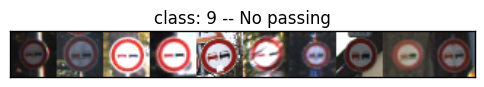

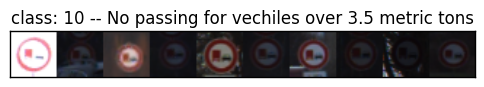

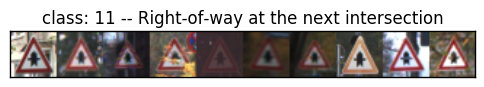

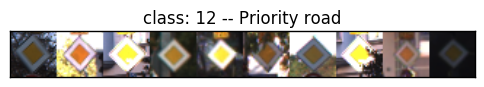

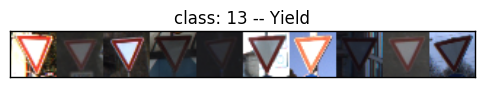

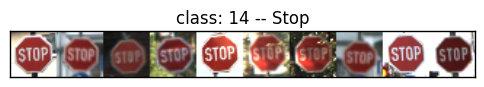

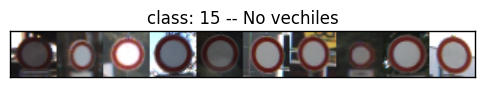

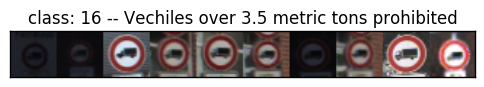

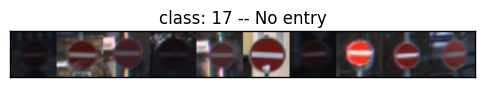

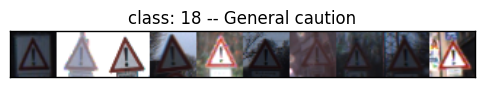

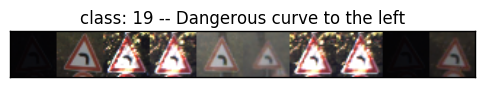

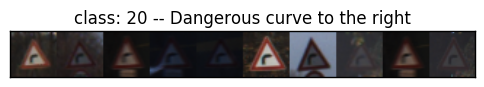

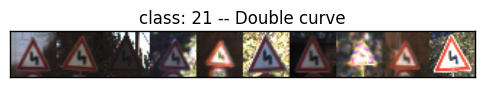

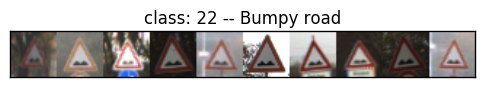

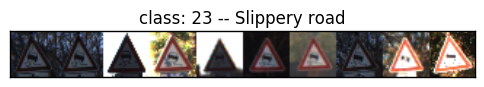

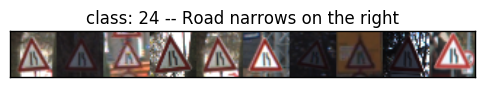

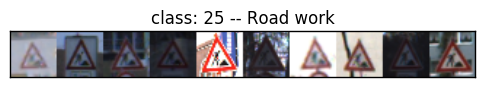

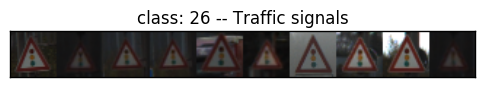

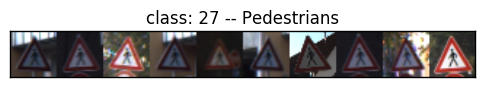

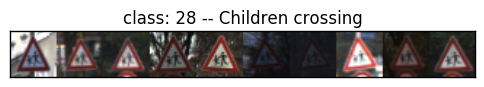

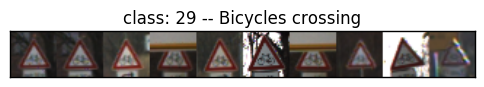

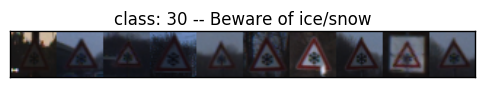

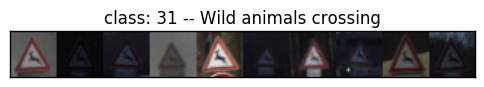

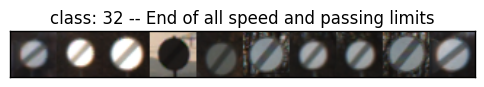

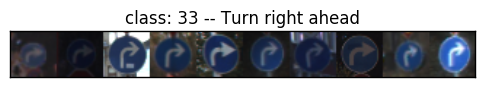

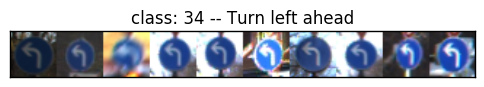

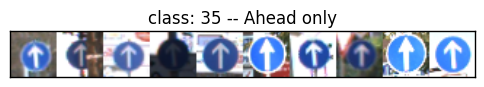

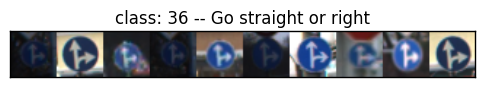

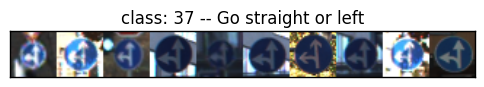

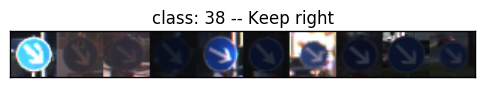

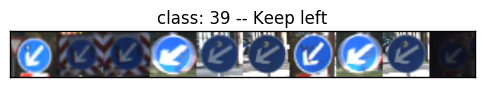

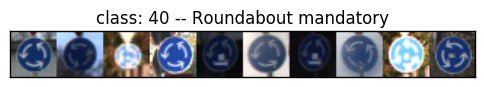

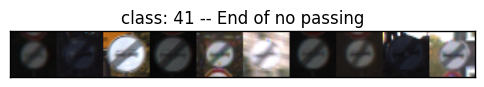

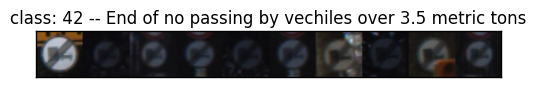

In [197]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

def plot_signs(X_train, y_train):
    sign_names = pd.read_csv('signnames.csv').set_index('ClassId').to_dict()['SignName']
    for klass in (set(y_train)):
        signs = [x for x,y in zip(X_train, y_train) if y==klass]    
        displayed = min(10, len(signs))
        np.random.shuffle(signs)
        plt.figure()
        f = plt.imshow(np.hstack(signs[0:displayed]))
        plt.title("class: {} -- {}".format(klass, sign_names[klass]))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    
plot_signs(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from sklearn.model_selection import train_test_split
from skimage.transform import rotate
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

def process_image(img):    
    for i in range(3):
        img[:,:,i] = cv2.equalizeHist(img[:,:,i])
    img = img.astype(np.float32)
    img /= 255
    return img    
    

            


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** as we have the dataset already cropped and resized, I only did histogram equalization on each channel (R, G and B) to improve contrast and normalized dividing by 255 to have values between 0 and 1.

In [2]:
### Generate data additional (if you want to!)

def jitter(img):
    degree_range = 15
    gamma_range = 0.2
    gaussian = 0.2
    
    #rotation
    degrees = np.random.randint(-degree_range, degree_range)
    img = rotate(img, degrees)    
    #gamma
    img = adjust_gamma(img, np.random.uniform(1 - gamma_range, 1 + gamma_range))
    if np.random.rand() < gaussian:
        img = random_noise(img, mode='localvar')
    return img

### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def read_train():
    training_file = 'data/train.p'
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    X_train, y_train = train['features'], train['labels']
    return X_train, y_train

def read_test():
    testing_file = 'data/test.p'
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    
    X_test, y_test = test['features'], test['labels']
    return X_test, y_test
    
def build_train():
    X_train, y_train = read_train()
    x_train = np.array([process_image(x) for x in X_train], dtype=np.float32)
    y_train = y_train.astype(np.uint8)
    return train_test_split(x_train, y_train, test_size=0.20, stratify = y_train ) 
        
def build_test():
    X_test, y_test = read_test()
    x_test = np.array([process_image(x) for x in X_test], dtype=np.float32)
    y_test = y_test.astype(np.uint8)
    return x_test, y_test


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** For the validation set I used 20% of the training data with a stratified sampling method. It was important to shuffle the training data to account for the effect described in the paper and the stratification per class was done to avoid class imbalance. This part is achieved with the *train_test_split* method from scikit-learn.

I used data augmentation to help avoid overfitting. I implemented a *generator* that reads the training data and adds *jitter* to each image lazily, so the model never sees the same image more than once. The jitter includes rotation, gamma correction and random noise (using gaussian-distributed additive noise).


In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def conv2d(x, filter_size, input_channels, output_channels, pooling=False):
    filter_shape = [filter_size,filter_size,input_channels,output_channels]
    weights = tf.Variable(tf.truncated_normal(shape=filter_shape, mean=0, stddev=0.1))    
    biases = tf.Variable(tf.constant(0.0, shape=[output_channels]))
    
    out = tf.nn.bias_add(tf.nn.conv2d(x, weights, strides=[1,1,1,1], padding='SAME'), biases)
    if pooling:
        out = tf.nn.max_pool(out, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    out = tf.nn.relu(out)
    return out, weights    

def fc(x, input_channels, output_channels, activation=True):
    weights = tf.Variable(tf.truncated_normal(shape=[input_channels, output_channels], mean=0, stddev=0.1))
    biases = tf.Variable(tf.constant(0.0, shape=[output_channels]))
    out = tf.matmul(x, weights) + biases
    if activation:
        out = tf.nn.relu(out)        
    return out, weights
    
def model(x, keep_prob, channels, num_classes):
    c1, c1_weights = conv2d(x, 1, channels, 3)
    c2, c2_weights = conv2d(c1, 3, 3, 16)    
    c3, c3_weights = conv2d(c2, 5, 16, 16, pooling=True)    
    c3 = tf.nn.dropout(c3, keep_prob)
    flat3 = flatten(c3)
    
    c4, c4_weights = conv2d(c3, 5, 16, 32)    
    c5, c5_weights = conv2d(c4, 5, 32, 32)
    c5 = tf.nn.dropout(c5, keep_prob)
    flat5 = flatten(c5)
    
    fc0 = tf.concat(1, [flat3, flat5])
    fc1, fc1_weights = fc(fc0, 12288, 256)
    fc2, fc2_weights = fc(fc1, 256, 256)
    fc3, fc3_weights = fc(fc2, 256, num_classes, activation=False)
    return fc3, [c1_weights, c2_weights, c3_weights, c4_weights, c5_weights, fc1_weights, fc2_weights, fc3_weights]


In [ ]:
def next_batch(x_data, y_data, batch_size, step):
    batch_start = step*batch_size
    batch_x = x_data[batch_start:batch_start + batch_size]
    batch_y = y_data[batch_start:batch_start + batch_size]    
    return batch_x, batch_y

def train_generator(x_data, y_data, batch_size):
    while True:
        for step in range(len(x_data)//batch_size):
            batch_start = step*batch_size
            batch_x = np.array([jitter(img) for img in x_data[batch_start:batch_start + batch_size]])
            batch_y = y_data[batch_start:batch_start + batch_size]    
            yield batch_x, batch_y
        
def evaluate(sess, loss_op, accuracy_op, x, y, keep_prob, x_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    steps_per_epoch = len(x_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = next_batch(x_data, y_data, BATCH_SIZE, step)      
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})        
        total_acc += (acc * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_acc/num_examples

def train(sess,
          input_tensors, 
          loss_op, accuracy_op,
          data_generator, evaluation, 
          learning_rate, steps_per_epoch, augmentation_factor,
          model_name):
    
    x, y, keep_prob = input_tensors
    
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op)
    
    saver = tf.train.Saver(max_to_keep=5)
    
    sess.run(tf.global_variables_initializer())
    
    #ckpt = tf.train.get_checkpoint_state('.')
    #if ckpt and ckpt.model_checkpoint_path:
    #    print(ckpt.model_checkpoint_path)
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    #    print("checkpoint restored.")
        
    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            batch_x, batch_y = next(data_generator) #next_batch(X_data, y_data, batch_size, step)
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        val_loss, val_acc = evaluation(sess, loss_op, accuracy_op, x, y, keep_prob)            
        print("epoch {}, loss={:.4f}, acc={:.4f}".format(i+1, val_loss, val_acc))
        
        saver.save(sess, model_name, global_step=i)
        



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The architecture I chose is based on the VGGNet by Simonyan & Zisserman but modified to include the "multi-stage" feature described in the paper by Semnet & LeCun. The outputs of stage 1 and stage 2 are both fed to the classifier.

Input: 32x32x3

Stage1:
-   Conv Layer 1: 5x5x32
-   Conv Layer 2: 3x3x16
-   Conv Layer 3: 5x5x16 (with max pooling)
-   Dropout
Stage 2:
-   Conv Layer 4: 5x5x32
-   Conv Layer 5: 5x5x32 (with max pooling)
-   Dropout
Stage 3:
- Flatten(Stage1, Stage2)
- Fully Connected (12288x256)
- Fully Connected (256, 256)
- Fully COnnected (256, 43)




In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

EPOCHS = 10
BATCH_SIZE = 200
LEARNING_RATE = 1e-3
NUM_CLASSES = 43
CHANNELS = 3
AUGMENTATION_FACTOR = 5

def main():
    X_visible, X_val, y_visible, y_val = build_train()
    
    generator = train_generator(X_visible, y_visible, BATCH_SIZE)
    steps_per_epoch = (AUGMENTATION_FACTOR * len(X_visible)) // BATCH_SIZE
    evaluation = partial(evaluate, x_data=X_val, y_data=y_val)
    
    tensor_x = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
    tensor_y = tf.placeholder(tf.int32, (None))
    tensor_keep_prob = tf.placeholder(tf.float32)
    
    y_ = tf.one_hot(tensor_y, NUM_CLASSES)
    logits, weights = model(tensor_x, tensor_keep_prob, CHANNELS, NUM_CLASSES)
    xentropy =  tf.nn.softmax_cross_entropy_with_logits(logits, y_)
    l2_loss = sum([tf.nn.l2_loss(w) for w in weights])
    loss_op = tf.reduce_mean(xentropy) + 1e-5 * l2_loss
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session() as sess:
        train(sess,
              (tensor_x, tensor_y, tensor_keep_prob), loss_op, accuracy_op,
              generator, evaluation, 
              LEARNING_RATE, steps_per_epoch, AUGMENTATION_FACTOR,
              'model1')
    
        print('running test')
        X_test, y_test = build_test()
        test_loss, test_acc = evaluate(sess, 
                                       loss_op, accuracy_op, 
                                       tensor_x, tensor_y, tensor_keep_prob, 
                                       X_test, y_test)
        print('test loss={:.4f}, acc={:.4f}'.format(test_loss, test_acc))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** AdamOptimizer, batch_size=200, epochs=10, learning_rate=1e-3. Dropout 0.5. This gave an accuracy of 0.9953 on the validation set. 

By training more epochs with a lower learning (10 epochs with the same starting learning rate, then 10 more epochs with half the initial learning rate and then 10 more epochs with 0.1 times the initial learning rate) I was able to improve the accuracy to 0.9979, and a corresponding accuracy of the test set of 0.xxxx.



### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** I started with the simplest approach using the LeNet architecture (only dropout and no L2 loss regularization) and no data augmentation and didn't have satisfying results. I did experiment adjusting the learning rate and adding more layers but it didn't work (either underfitting or overfitting). Later I discovered I had a mistake in the preprocessing code so that could explain those bad results. After that I moved to the techniques described in the paper by Sermanet & LeCun and the scores improved significantly.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** I chose a few different local signs with different characteristics and increasing difficulty to test the behavior of the model. 

The first four signs are speed limit signs that are very similar to the training data set, except they have "km/h" written on the sign.

The yield sign I chose is also very similar.

Next I selected two "mandatory roundabout" signs that are similar except for the colour. In my country they have a red border instead of blue. As the model was trained with RGB images I don't expect it to work, but maybe I'm wrong. In case it doesn't work I might try to swap the R and B channels to confirm the colour is indeed the only issue. By reading some papers I had the impression there wasn't consensus on which was better, RGB or Grayscale, but I just realized one concrete advantage of using Grayscale only.

The next two signs do not have a corresponding in the training data set. The first sign has an arrow similar to "turn left ahead", except there's a "cross" meaning "prohibited turn left ahead". And the second one is identifical to the first but rotated.

And finally, the last two mean "pedestrian crossing", but slightly different from the german ones in the drawing, colors and shapes.



In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

import skimage
from scipy.misc import imread
import seaborn as sns


def build_extra():
    X_extra = []
    for filename in ['110', '80', 'a1', 'a2', 'a3', 'a4', 'b1', 'c1', 'c2', 'd1', 'd2', 'e1', 'e2']:
        image = imread('extra/{}.png'.format(filename))
        image = image[:,:,:3] #exclude last channel (transparency)
        image = skimage.transform.resize(image, (32, 32))
        image = cv2.convertScaleAbs(255 * image)
        image = process_image(image)
        X_extra.append(image)
    return np.array(X_extra)
    

X_extra = build_extra()


tensor_x = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
tensor_keep_prob = tf.placeholder(tf.float32)

logits, weights = model(tensor_x, tensor_keep_prob, CHANNELS, NUM_CLASSES)
top_5 = tf.nn.top_k(logits, 5)

saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('.')

    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print("checkpoint {} restored.".format(ckpt.model_checkpoint_path))

    print('running test')
    preds = sess.run(top_5, feed_dict={tensor_x: X_extra, tensor_keep_prob:1.0})


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:** No. Of all sign images the only correctly predicted was the "yield" signal. I suspect the text "km/h" bellow speed signals was confusing the model so I downloaded two new signals from Wikipedia. One was correctly predicted but the other wasn't, probably because the "typeface" used for speed digits was different than german ones. 

In summary, despite the high accuracy in the test set this solution couldn't generalize to new data. Contributing factors are varying angles, colors, typefaces, etc. I suspect part of it could be improved to a limited extent by adding different kinds of jitter.


In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

sign_names = pd.read_csv('signnames.csv').set_index('ClassId').to_dict()['SignName']

for indices, values, img, in zip(preds.indices, preds.values, X_extra):
    labels = [sign_names[i] for i in indices]
    f, ax = plt.subplots(1, 2, figsize=(3,3))
    sns.barplot(x=values, y=labels, ax=ax[0], orient='h', palette='Blues_d')
    ax[1].imshow(img)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** My code was already modularized, for instance training and evaluation were separate and I had already implemented saving & restore capability to be able to train more epochs from where it stopped, so this step was not complicated. I just needed to restore the checkpoint and run a tf.nn.top_k on the logits tensor.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.